In [37]:
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [4]:
import numpy as np
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

In [6]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [7]:
from tqdm import tqdm
from tabulate import tabulate

# Example 1

In [ ]:
#https://www.kaggle.com/epeterson17/few-shot-learning-of-rice-leaf-diseases (Example 1)
#https://www.kaggle.com/vbookshelf/rice-leaf-disease-analyzer-tensorflow-js-web-app (Example 2)

In [8]:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y)

In [9]:
data = Dataset("C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized", test_size=0.3, img_size=224)
print(data.X.shape, data.y.shape)

(998, 224, 224, 3) (998, 17)


In [10]:
embed = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)
X_embedding = embed(data.X)
X_test_embedding = embed(data.X_test)
print(X_embedding.shape, X_test_embedding.shape)

(998, 2048) (428, 2048)


In [18]:
def make_model(
    nclasses: int, *, dropout_rate: float, nhiddenunits: int, l2_regularization: float
) -> tf.keras.Model:
    model = tf.keras.Sequential()
    # One fully connected hidden layer
    model.add(L.Dense(nhiddenunits, activation="relu", kernel_regularizer=l2(l2_regularization)))
    model.add(L.Dropout(dropout_rate))
    # Output layer
    model.add(L.Dense(nclasses, activation="softmax", kernel_regularizer=l2(l2_regularization)))
    return model

In [28]:
# Model based on base paper
def make_model(
    nclasses: int, *, dropout_rate: float
) -> tf.keras.Model:
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(MaxPooling2D(pool_size = (2,2)))
    #model.add(Conv2D(24, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(32, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(48, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    #model.add(Dense(128,activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(nclasses, activation="softmax"))
    return model

In [29]:
def evaluate_model(
    nclasses, X, y, X_dev, y_dev, *,
    epochs: int, batch_size: int, learning_rate: float,
    model_maker = make_model, **model_params
) -> tuple:
    
    # Math to compute the learning rate schedule. We will divide our
    # learning rate by a factor of 10 every 30% of the optimizer's
    # total steps.
    steps_per_epoch = math.ceil(len(X) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Make and compile the model.
    model = model_maker(nclasses, **model_params)
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the dev set.
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev, y_dev))
    _, train_acc = model.evaluate(X, y, batch_size=batch_size, verbose=0)
    _, dev_acc = model.evaluate(X_dev, y_dev, batch_size=batch_size, verbose=0)
    return model, train_acc, dev_acc

In [30]:
def cv_evaluate_model(
    X, y, labels, *, nfolds: int, nrepeats: int, epochs: int, batch_size: int,
    learning_rate: float, model_maker, verbose: bool = True, seed: int = 0,
    **model_params
) -> dict:
    """
    Performs `nfolds` cross-validated training and evaluation of a
    model hyperparameter configuration. Returns a dictionary of
    statistics about the outcome of the cross-validated experiment.
    """
    _, nclasses = y.shape
    train_accs, dev_accs = [], []
    
    # Train and evaluate the model for each fold.
    for train_index, dev_index in tqdm(
        RepeatedStratifiedKFold(
            n_splits=nfolds, n_repeats=nrepeats, random_state=seed
        ).split(X, labels),
        total=nfolds*nrepeats, disable=not verbose
    ):
        
        # Select the data for this fold.
        X_train_fold = tf.gather(X, train_index) 
        y_train_fold = tf.gather(y, train_index)
        X_dev_fold = tf.gather(X, dev_index)
        y_dev_fold = tf.gather(y, dev_index)
        
        # Train and evaluate the model.
        _, train_acc, dev_acc = evaluate_model(
            nclasses,
            X_train_fold,
            y_train_fold,
            X_dev_fold,
            y_dev_fold,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            model_maker=model_maker,
            **model_params
        )
        train_accs.append(train_acc)
        dev_accs.append(dev_acc)
    
    # Aggregate.
    results = {
        "train_mean": np.mean(train_accs),
        "train_std": np.std(train_accs),
        "dev_mean": np.mean(dev_accs),
        "dev_std": np.std(dev_accs)
    }
    
    # Report.
    if verbose:
        print(
            tabulate(
                [
                    ["Train", results["train_mean"], results["train_std"]],
                    ["Dev", results["dev_mean"], results["dev_std"]]
                ],
                headers=["Set", "Mean", "Std. Dev."]
            )
        )
    
    return results

In [23]:
# We'll refer to these values throughout the notebook.
default_cv_evaluate_params = {
    "X": X_embedding,
    "y": data.y,
    "labels": data.labels,
    "nfolds": 10,
    "nrepeats": 3,
    "model_maker": make_model,
    "epochs": 100,  #200
    "batch_size": 64,  #32
    "verbose": False,
    "learning_rate": 0.0001, #0.003
    "dropout_rate": 0.3,
    "nhiddenunits": 64,
    "l2_regularization": 1e-6 #0.000001
}

In [31]:
# We'll refer to these values throughout the notebook.
# Parameters based on base paper
default_cv_evaluate_params1 = {
    "X": data.X,
    "y": data.y,
    "labels": data.labels,
    "nfolds": 10,
    "nrepeats": 3,
    "model_maker": make_model,
    "epochs": 100,
    "batch_size": 64,
    "verbose": False,
    "learning_rate": 0.0001,
    "dropout_rate": 0.3,
}

In [19]:
_ = cv_evaluate_model(
    **{
        **default_cv_evaluate_params,
        "verbose": True
    }
)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [13:20<00:00, 26.68s/it]

Set        Mean    Std. Dev.
-----  --------  -----------
Train  0.981666    0.0161947
Dev    0.858101    0.0371086


In [24]:
_ = cv_evaluate_model(
    **{
        **default_cv_evaluate_params,
        "verbose": True
    }
)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/100
15/15 [==============================] - 22s 750ms/step - loss: 5.5366 - accuracy: 0.0995 - val_loss: 3.1461 - val_accuracy: 0.2900
Epoch 2/100
15/15 [==============================] - 6s 423ms/step - loss: 3.4288 - accuracy: 0.2384 - val_loss: 2.4975 - val_accuracy: 0.3300
Epoch 3/100
15/15 [==============================] - 6s 461ms/step - loss: 2.5590 - accuracy: 0.3050 - val_loss: 2.1998 - val_accuracy: 0.3600
Epoch 4/100
15/15 [==============================] - 6s 434ms/step - loss: 2.2063 - accuracy: 0.3283 - val_loss: 2.0291 - val_accuracy: 0.4200
Epoch 5/100
15/15 [==============================] - 6s 429ms/step - loss: 2.0184 - accuracy: 0.4060 - val_loss: 1.8743 - val_accuracy: 0.4900
Epoch 6/100
15/15 [==============================] - 7s 491ms/step - loss: 1.8454 - accuracy: 0.4598 - val_loss: 1.7684 - val_accuracy: 0.5000
Epoch 7/100
15/15 [==============================] - 6s 457ms/step - loss: 1.6777 - accuracy: 0.4999 - val_loss: 1.6545 - val_accuracy: 0.550

  0%|                                                                                           | 0/30 [05:44<?, ?it/s]


KeyboardInterrupt: 

In [32]:
# Results based on base paper (ye run kro)
_ = cv_evaluate_model(
    **{
        **default_cv_evaluate_params1,
        "verbose": True
    }
)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/100
15/15 [==============================] - 395s 25s/step - loss: 9.2049 - accuracy: 0.2612 - val_loss: 27.9479 - val_accuracy: 0.1300
Epoch 2/100
15/15 [==============================] - 359s 24s/step - loss: 1.4978 - accuracy: 0.7311 - val_loss: 5.5575 - val_accuracy: 0.1800
Epoch 3/100
15/15 [==============================] - 360s 24s/step - loss: 0.5166 - accuracy: 0.8073 - val_loss: 7.3043 - val_accuracy: 0.2000
Epoch 4/100
15/15 [==============================] - 356s 24s/step - loss: 0.3329 - accuracy: 0.8755 - val_loss: 4.5136 - val_accuracy: 0.2900
Epoch 5/100
15/15 [==============================] - 265s 17s/step - loss: 0.2778 - accuracy: 0.8996 - val_loss: 3.7999 - val_accuracy: 0.4400
Epoch 6/100
15/15 [==============================] - 179s 12s/step - loss: 0.2095 - accuracy: 0.9387 - val_loss: 5.3794 - val_accuracy: 0.3600
Epoch 7/100
15/15 [==============================] - 162s 11s/step - loss: 0.2402 - accuracy: 0.9299 - val_loss: 4.3455 - val_accuracy: 0.410

  0%|                                                                                           | 0/30 [43:33<?, ?it/s]


KeyboardInterrupt: 

In [36]:
X = data.X
y = data.y
labels = data.labels
train_accs, test_accs = [], []
history = []
    
# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=0
    ).split(X, labels),
    total=10*3, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X, train_index) 
    y_train = tf.gather(y, train_index)
    X_test = tf.gather(X, test_index)
    y_test = tf.gather(y, test_index)
    
    #Define Model
    model = Sequential()
    model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    #model.add(Conv2D(24, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(48, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(17, activation="softmax"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / 64) #batch - 64
    third_of_total_steps = math.floor(100 * steps_per_epoch / 3) #epoch - 100
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                0.0001,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=64, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/100
 5/16 [========>.....................] - ETA: 41s - loss: 3.6495 - accuracy: 0.0995

  0%|                                                                                           | 0/30 [00:30<?, ?it/s]


KeyboardInterrupt: 

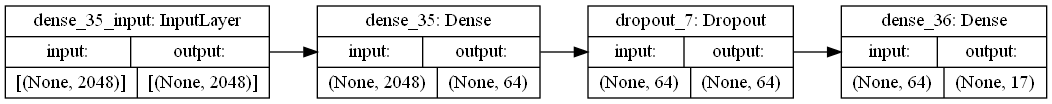

In [104]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [109]:
train_accs, test_accs = [], []
history
X = X_embedding
    
# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=0
    ).split(X, labels),
    total=10*3, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X, train_index) 
    y_train = tf.gather(y, train_index)
    X_test = tf.gather(X, test_index)
    y_test = tf.gather(y, test_index)
    
    #Define Model
    model = Sequential()
    # One fully connected hidden layer
    model.add(L.Dense(64, activation="relu", kernel_regularizer=l2(0.000001)))
    model.add(L.Dropout(0.3))
    # Output layer
    model.add(L.Dense(17, activation="softmax", kernel_regularizer=l2(0.000001)))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / 32) #batch - 64
    third_of_total_steps = math.floor(200 * steps_per_epoch / 3) #epoch - 100
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                0.003,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = (model.fit(X_train, y_train, batch_size=32, epochs=200, verbose=1, validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=32, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/200
32/32 [==============================] - 3s 74ms/step - loss: 3.7888 - accuracy: 0.2509 - val_loss: 1.5258 - val_accuracy: 0.5400
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 1.6822 - accuracy: 0.4844 - val_loss: 0.8684 - val_accuracy: 0.7200
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 1.2152 - accuracy: 0.5750 - val_loss: 0.6233 - val_accuracy: 0.7800
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.9914 - accuracy: 0.6320 - val_loss: 0.5796 - val_accuracy: 0.8200
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.9164 - accuracy: 0.6818 - val_loss: 0.5492 - val_accuracy: 0.8200
Epoch 6/200
32/32 [==============================] - 0s 5ms/step - loss: 0.8183 - accuracy: 0.7214 - val_loss: 0.4006 - val_accuracy: 0.8900
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.8076 - accuracy: 0.6990 - val_loss: 0.3112 - val_accuracy: 0.9000
Epoch 8/200


Epoch 59/200
32/32 [==============================] - 0s 6ms/step - loss: 0.3981 - accuracy: 0.8438 - val_loss: 0.0708 - val_accuracy: 0.9700
Epoch 60/200
32/32 [==============================] - 0s 6ms/step - loss: 0.4153 - accuracy: 0.8276 - val_loss: 0.0809 - val_accuracy: 0.9600
Epoch 61/200
32/32 [==============================] - 0s 6ms/step - loss: 0.4892 - accuracy: 0.8157 - val_loss: 0.0490 - val_accuracy: 0.9800
Epoch 62/200
32/32 [==============================] - 0s 6ms/step - loss: 0.4440 - accuracy: 0.8326 - val_loss: 0.0470 - val_accuracy: 0.9900
Epoch 63/200
32/32 [==============================] - 0s 6ms/step - loss: 0.3630 - accuracy: 0.8653 - val_loss: 0.0857 - val_accuracy: 0.9700
Epoch 64/200
32/32 [==============================] - 0s 6ms/step - loss: 0.4533 - accuracy: 0.8224 - val_loss: 0.0541 - val_accuracy: 0.9800
Epoch 65/200
32/32 [==============================] - 0s 5ms/step - loss: 0.3768 - accuracy: 0.8597 - val_loss: 0.0345 - val_accuracy: 0.9900
Epoch 

32/32 [==============================] - 0s 5ms/step - loss: 0.3575 - accuracy: 0.8653 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 174/200
32/32 [==============================] - 0s 6ms/step - loss: 0.3220 - accuracy: 0.8755 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 175/200
32/32 [==============================] - 0s 6ms/step - loss: 0.3419 - accuracy: 0.8688 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 176/200
32/32 [==============================] - 0s 5ms/step - loss: 0.2872 - accuracy: 0.8789 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 177/200
32/32 [==============================] - 0s 5ms/step - loss: 0.2840 - accuracy: 0.9021 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 178/200
32/32 [==============================] - 0s 5ms/step - loss: 0.3559 - accuracy: 0.8608 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 179/200
32/32 [==============================] - 0s 5ms/step - loss: 0.2925 - accuracy: 0.8890 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 180/200

  3%|██▊                                                                                | 1/30 [00:41<19:50, 41.06s/it]

Epoch 1/200
32/32 [==============================] - 1s 17ms/step - loss: 4.2731 - accuracy: 0.2074 - val_loss: 1.7101 - val_accuracy: 0.3900
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 1.8266 - accuracy: 0.3913 - val_loss: 1.4099 - val_accuracy: 0.5100
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 1.5589 - accuracy: 0.5025 - val_loss: 1.1266 - val_accuracy: 0.6600
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 1.3272 - accuracy: 0.5483 - val_loss: 0.8447 - val_accuracy: 0.7100
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 1.1704 - accuracy: 0.5989 - val_loss: 0.6578 - val_accuracy: 0.7900
Epoch 6/200
32/32 [==============================] - 0s 5ms/step - loss: 1.0462 - accuracy: 0.6130 - val_loss: 0.5941 - val_accuracy: 0.8000
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.9604 - accuracy: 0.6507 - val_loss: 0.5490 - val_accuracy: 0.7700
Epoch 8/200


Epoch 59/200
32/32 [==============================] - 0s 5ms/step - loss: 0.4686 - accuracy: 0.8213 - val_loss: 0.1164 - val_accuracy: 0.9900
Epoch 60/200
32/32 [==============================] - 0s 6ms/step - loss: 0.5287 - accuracy: 0.8225 - val_loss: 0.0729 - val_accuracy: 0.9900
Epoch 61/200
32/32 [==============================] - 0s 6ms/step - loss: 0.5042 - accuracy: 0.8198 - val_loss: 0.1034 - val_accuracy: 0.9900
Epoch 62/200
32/32 [==============================] - 0s 4ms/step - loss: 0.4761 - accuracy: 0.8059 - val_loss: 0.1129 - val_accuracy: 0.9800
Epoch 63/200
32/32 [==============================] - 0s 4ms/step - loss: 0.5275 - accuracy: 0.7928 - val_loss: 0.0922 - val_accuracy: 0.9900
Epoch 64/200
32/32 [==============================] - 0s 6ms/step - loss: 0.4972 - accuracy: 0.8071 - val_loss: 0.1059 - val_accuracy: 0.9900
Epoch 65/200
32/32 [==============================] - 0s 6ms/step - loss: 0.5354 - accuracy: 0.8002 - val_loss: 0.0844 - val_accuracy: 0.9900
Epoch 

  3%|██▊                                                                                | 1/30 [00:56<27:10, 56.21s/it]


KeyboardInterrupt: 

In [110]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

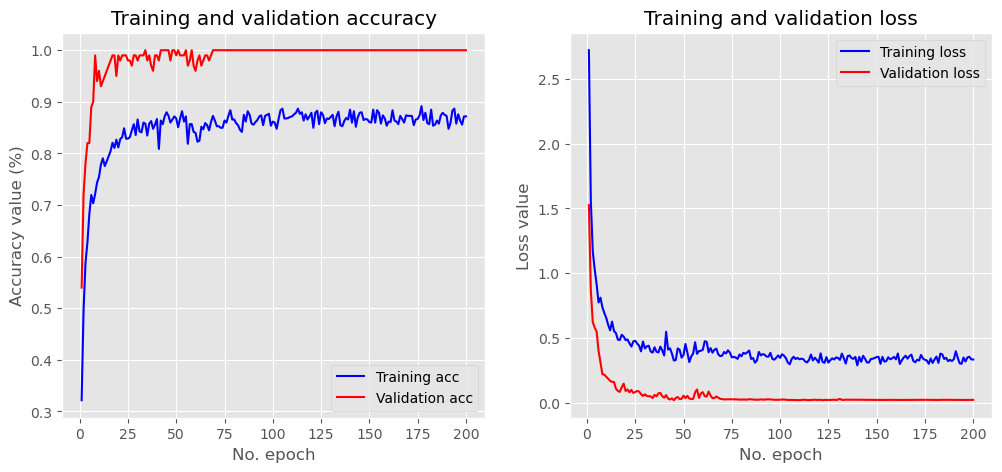

In [111]:
plot_history(history)

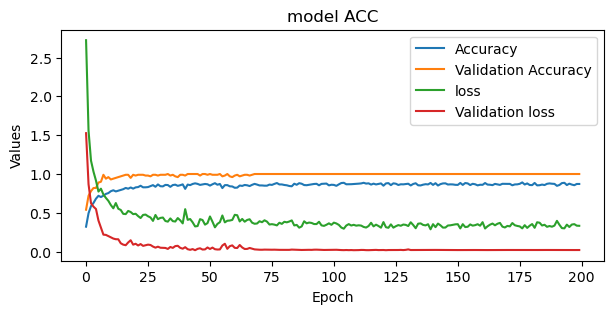

In [112]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("model ACC")
plt.ylabel("Values")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation loss"])
plt.show()

# Example 2

In [86]:
labels1 = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized')
labels1

['BLB1',
 'BPH1',
 'BPH2',
 'Brown_Spot1',
 'False_Smut1',
 'False_Smut2',
 'Healthy1',
 'Healthy2',
 'Healthy3',
 'Hispa1',
 'Hispa2',
 'Neck_Blast1',
 'Sheath_Blight_Rot1',
 'Sheath_Blight_Rot2',
 'Sheath_Blight_Rot3',
 'Stemborer1',
 'Stemborer2']

In [48]:
BLB1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\BLB1')
BPH1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\BPH1')
BPH2_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\BPH2')
Brown_Spot1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Brown_Spot1')
False_Smut1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\False_Smut1')
False_Smut2_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\False_Smut2')
Healthy1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Healthy1')
Healthy2_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Healthy2')
Healthy3_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Healthy3')
Hispa1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Hispa1')
Hispa2_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Hispa2')
Neck_Blast1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Neck_Blast1')
Sheath_Blight_Rot1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Sheath_Blight_Rot1')
Sheath_Blight_Rot2_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Sheath_Blight_Rot2')
Sheath_Blight_Rot3_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Sheath_Blight_Rot3')
Stemborer1_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Stemborer1')
Stemborer2_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Stemborer2')

In [49]:
print(len(BLB1_list))
print(len(BPH1_list))
print(len(BPH2_list))
print(len(Brown_Spot1_list))
print(len(False_Smut1_list))
print(len(False_Smut2_list))
print(len(Healthy1_list))
print(len(Healthy2_list))
print(len(Healthy3_list))
print(len(Hispa1_list))
print(len(Hispa2_list))
print(len(Neck_Blast1_list))
print(len(Sheath_Blight_Rot1_list))
print(len(Sheath_Blight_Rot2_list))
print(len(Sheath_Blight_Rot3_list))
print(len(Stemborer1_list))
print(len(Stemborer2_list))

138
50
21
111
66
27
96
71
67
53
20
286
70
77
72
180
21


In [50]:
df_BLB1 = pd.DataFrame(BLB1_list, columns=['image'])
df_BPH1 = pd.DataFrame(BPH1_list, columns=['image'])
df_BPH2 = pd.DataFrame(BPH2_list, columns=['image'])
df_Brown_Spot1 = pd.DataFrame(Brown_Spot1_list, columns=['image'])
df_False_Smut1 = pd.DataFrame(False_Smut1_list, columns=['image'])
df_False_Smut2 = pd.DataFrame(False_Smut2_list, columns=['image'])
df_Healthy1 = pd.DataFrame(Healthy1_list, columns=['image'])
df_Healthy2 = pd.DataFrame(Healthy2_list, columns=['image'])
df_Healthy3 = pd.DataFrame(Healthy3_list, columns=['image'])
df_Hispa1 = pd.DataFrame(Hispa1_list, columns=['image'])
df_Hispa2 = pd.DataFrame(Hispa2_list, columns=['image'])
df_Neck_Blast1 = pd.DataFrame(Neck_Blast1_list, columns=['image'])
df_Sheath_Blight_Rot1 = pd.DataFrame(Sheath_Blight_Rot1_list, columns=['image'])
df_Sheath_Blight_Rot2 = pd.DataFrame(Sheath_Blight_Rot2_list, columns=['image'])
df_Sheath_Blight_Rot3 = pd.DataFrame(Sheath_Blight_Rot3_list, columns=['image'])
df_Stemborer1 = pd.DataFrame(Stemborer1_list, columns=['image'])
df_Stemborer2 = pd.DataFrame(Stemborer2_list, columns=['image'])

In [51]:
df_BLB1['target'] = 'BLB1'
df_BPH1['target'] = 'BPH1'
df_BPH2['target'] = 'BPH2'
df_Brown_Spot1['target'] = 'Brown_Spot1'
df_False_Smut1['target'] = 'False_Smut1'
df_False_Smut2['target'] = 'False_Smut2'
df_Healthy1['target'] = 'Healthy1'
df_Healthy2['target'] = 'Healthy2'
df_Healthy3['target'] = 'Healthy3'
df_Hispa1['target'] = 'Hispa1'
df_Hispa2['target'] = 'Hispa2'
df_Neck_Blast1['target'] = 'Neck_Blast1'
df_Sheath_Blight_Rot1['target'] = 'Sheath_Blight_Rot1'
df_Sheath_Blight_Rot2['target'] = 'Sheath_Blight_Rot2'
df_Sheath_Blight_Rot3['target'] = 'Sheath_Blight_Rot3'
df_Stemborer1['target'] = 'Stemborer1'
df_Stemborer2['target'] = 'Stemborer2'

In [52]:
df_data = pd.concat([df_BLB1, df_BPH1, df_BPH2, df_Brown_Spot1, df_False_Smut1, df_False_Smut2,\
                    df_Healthy1, df_Healthy2, df_Healthy3, df_Hispa1, df_Hispa2, df_Neck_Blast1, \
                    df_Sheath_Blight_Rot1, df_Sheath_Blight_Rot2, df_Sheath_Blight_Rot3, \
                    df_Stemborer1, df_Stemborer2], axis=0).reset_index(drop=True)

In [53]:
print(df_data.shape)

(1426, 2)


In [54]:
df_data

,image,target
0,BLB1_02ca69d3-b850-4091-af2a-bb72a07b7cd1.jpeg,BLB1
1,BLB1_04fd04a1-3992-4e35-bcc9-713dc3ee0afd.jpeg,BLB1
2,BLB1_09001d16-4e5f-4baf-880f-1511064e1015.jpeg,BLB1
3,BLB1_0cf4a332-f2d5-41f9-ae4d-5d5407753243.jpeg,BLB1
4,BLB1_0dec2057-f3da-4fcb-9290-4eda2904024b.jpeg,BLB1
...,...,...
1421,Stemborer2_e6a7c090-c85d-48f4-9fe6-2863d4fcf61...,Stemborer2
1422,Stemborer2_f0f6fd0b-77b1-46c1-bc5d-271ada7640a...,Stemborer2
1423,Stemborer2_f2961d08-7e3b-4d05-8a4d-95c4cf5cf33...,Stemborer2
1424,Stemborer2_f7cad769-ece7-4676-86bc-084188a9fd7...,Stemborer2


In [55]:
df_data['target'].value_counts()

Neck_Blast1           286
Stemborer1            180
BLB1                  138
Brown_Spot1           111
Healthy1               96
Sheath_Blight_Rot2     77
Sheath_Blight_Rot3     72
Healthy2               71
Sheath_Blight_Rot1     70
Healthy3               67
False_Smut1            66
Hispa1                 53
BPH1                   50
False_Smut2            27
BPH2                   21
Stemborer2             21
Hispa2                 20
Name: target, dtype: int64

In [56]:
df_combined = pd.get_dummies(df_data, columns=['target'])
df_combined

,image,target_BLB1,target_BPH1,target_BPH2,target_Brown_Spot1,target_False_Smut1,target_False_Smut2,target_Healthy1,target_Healthy2,target_Healthy3,target_Hispa1,target_Hispa2,target_Neck_Blast1,target_Sheath_Blight_Rot1,target_Sheath_Blight_Rot2,target_Sheath_Blight_Rot3,target_Stemborer1,target_Stemborer2
0,BLB1_02ca69d3-b850-4091-af2a-bb72a07b7cd1.jpeg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BLB1_04fd04a1-3992-4e35-bcc9-713dc3ee0afd.jpeg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,BLB1_09001d16-4e5f-4baf-880f-1511064e1015.jpeg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,BLB1_0cf4a332-f2d5-41f9-ae4d-5d5407753243.jpeg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,BLB1_0dec2057-f3da-4fcb-9290-4eda2904024b.jpeg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,Stemborer2_e6a7c090-c85d-48f4-9fe6-2863d4fcf61...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1422,Stemborer2_f0f6fd0b-77b1-46c1-bc5d-271ada7640a...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1423,Stemborer2_f2961d08-7e3b-4d05-8a4d-95c4cf5cf33...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1424,Stemborer2_f7cad769-ece7-4676-86bc-084188a9fd7...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [92]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [59]:
X1 = df_combined['image']
y1 = df_combined.drop(['image'], axis = 1)

In [62]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

In [64]:
y_train1.head()

,target_BLB1,target_BPH1,target_BPH2,target_Brown_Spot1,target_False_Smut1,target_False_Smut2,target_Healthy1,target_Healthy2,target_Healthy3,target_Hispa1,target_Hispa2,target_Neck_Blast1,target_Sheath_Blight_Rot1,target_Sheath_Blight_Rot2,target_Sheath_Blight_Rot3,target_Stemborer1,target_Stemborer2
511,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
530,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
866,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
993,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
656,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [66]:
print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(1140,)
(286,)
(1140, 17)
(286, 17)


In [75]:
df_train = pd.get_dummies(X_train1, columns=['target'])
df_test = pd.get_dummies(X_test1, columns=['target'])

In [76]:
train_len = len(df_train)
test_len = len(df_test)

In [77]:
# separate the train and val sets
df_train = df_combined[test_len:]
df_test = df_combined[:test_len]

In [79]:
print (df_train.shape)
print (df_test.shape)

(1140, 18)
(286, 18)


In [80]:
#df_combined.to_csv('df_rice_disease_data.csv', index=False)
#df_train.to_csv('df_train_rice_disease_data.csv', index=False)
#df_test.to_csv('df_test_rice_disease_data.csv', index=False)

In [83]:
image_dir = 'image_dir'
os.mkdir(image_dir)

In [128]:
import shutil
for fname in BLB1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\BLB1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in BPH1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\BPH1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in BPH2_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\BPH2\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Brown_Spot1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Brown_Spot1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in False_Smut1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\False_Smut1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in False_Smut2_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\False_Smut2\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Healthy1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Healthy1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Healthy2_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Healthy2\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Healthy3_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Healthy3\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Hispa1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Hispa1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Hispa2_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Hispa2\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Neck_Blast1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Neck_Blast1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Sheath_Blight_Rot1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Sheath_Blight_Rot1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Sheath_Blight_Rot2_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Sheath_Blight_Rot2\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Sheath_Blight_Rot3_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Sheath_Blight_Rot3\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Stemborer1_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Stemborer1\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
for fname in Stemborer2_list:
    path = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\Stemborer2\\'
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [129]:
len(os.listdir('image_dir'))

1426

In [138]:
df1 = pd.read_csv('df_train_rice_disease_data.csv')
columns2 = df1.columns[1:18]
columns2

Index(['target_BLB1', 'target_BPH1', 'target_BPH2', 'target_Brown_Spot1',
       'target_False_Smut1', 'target_False_Smut2', 'target_Healthy1',
       'target_Healthy2', 'target_Healthy3', 'target_Hispa1', 'target_Hispa2',
       'target_Neck_Blast1', 'target_Sheath_Blight_Rot1',
       'target_Sheath_Blight_Rot2', 'target_Sheath_Blight_Rot3',
       'target_Stemborer1', 'target_Stemborer2'],
      dtype='object')

In [143]:
import albumentations as albu


def augment_image(augmentation, image):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix

In [146]:
# Define the transforms


aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])

C:\ProgramData\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


### Train Generator

In [147]:
#for cv2 Installation
#https://medium.com/@pranav.keyboard/installing-opencv-for-python-on-windows-using-anaconda-or-winpython-f24dd5c895eb
import cv2
def train_generator(batch_size=8):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train_rice_disease_data.csv', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create y_train
            # ===============
                cols = columns2
                y_train = df[cols]
                y_train = np.asarray(y_train) 

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
              
            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                          
                
            # Normalize the images
            X_train = X_train/255

In [148]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train2, y_train2 = next(train_gen)

print(X_train2.shape)
print(y_train2.shape)

KeyboardInterrupt: 

### Validate Generator 

In [ ]:
def val_generator(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test_rice_disease_data.csv', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_val
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image
                
                
            
            
            # Create y_val
            # ===============

                cols = columns2
                y_val = df[cols]
                y_val = np.asarray(y_val) 

                # change the shape to (batch_size, 1)
                #y_val = y_val.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
            
                
                          
                
            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [ ]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val2, y_val2 = next(val_gen)

print(X_val2.shape)
print(y_val2.shape)

### Test Generator

In [ ]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test_rice_disease_data.csv', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_test
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image
                
                 
                
            # Normalize the images
            X_test = X_test/255

            yield X_test

In [ ]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test2 = next(test_gen)

print(X_test1.shape)

### Model Architecture

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger,LearningRateScheduler)

In [ ]:
model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(17, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_test)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=100, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

In [ ]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head()

In [ ]:
model.metrics_names

In [ ]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate_generator(val_gen, 
                        steps=len(df_test))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

In [ ]:
test_gen = test_generator(batch_size=1)
preds = model.predict_generator(test_gen, steps=len(df_test), verbose=1)

In [ ]:
# get y_pred as index values
y_pred = np.argmax(preds, axis=1)
y_pred

In [ ]:
# get y_true as index values

cols = columns2
y_true = df_test[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)

y_true

In [ ]:
# Compare y_true and y_pred

print(y_pred)
print(y_true)

In [ ]:
import itertools
cm = confusion_matrix(y_true, y_pred)

In [ ]:
cm_plot_labels = columns1
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
report = classification_report(y_true, y_pred, target_names=columns1)
print(report)

# Example 3

In [39]:
dataset_list = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\BLB1')
print (len(dataset_list))

17


In [109]:
import pathlib
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization
from keras import regularizers

In [110]:
data_dir ="C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized"
data_dir = pathlib.Path(data_dir)

CLASS_NAMES = np.array(['BLB1','BPH1','BPH2','Brown_Spot1','False_Smut1','False_Smut2','Healthy1','Healthy2','Healthy3',
                       'Hispa1','Hispa2','Neck_Blast1','Sheath_Blight_Rot1','Sheath_Blight_Rot2','Sheath_Blight_Rot3',
                       'Stemborer1','Stemborer2'])

print('Class Names: ', CLASS_NAMES)

Class Names:  ['BLB1' 'BPH1' 'BPH2' 'Brown_Spot1' 'False_Smut1' 'False_Smut2' 'Healthy1'
 'Healthy2' 'Healthy3' 'Hispa1' 'Hispa2' 'Neck_Blast1'
 'Sheath_Blight_Rot1' 'Sheath_Blight_Rot2' 'Sheath_Blight_Rot3'
 'Stemborer1' 'Stemborer2']


In [205]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [206]:
image_generator = ImageDataGenerator(validation_split=0.2)

train_data_gen = image_generator.flow_from_directory(data_dir,
                                                     subset='training',
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='sparse')
val_data_gen = image_generator.flow_from_directory(data_dir,
                                                     subset='validation',
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='sparse')

Found 1145 images belonging to 17 classes.
Found 281 images belonging to 17 classes.


In [207]:
image_train_gen = ImageDataGenerator(rescale=1./255)
train_data_gen = image_train_gen.flow_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='sparse')

Found 1426 images belonging to 17 classes.


In [208]:
imgage_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = imgage_val_gen.flow_from_directory(data_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=(IMG_HEIGHT,IMG_WIDTH),
                                               class_mode='sparse')

Found 1426 images belonging to 17 classes.


In [220]:
def plotImages(image_arr):
    fig,axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

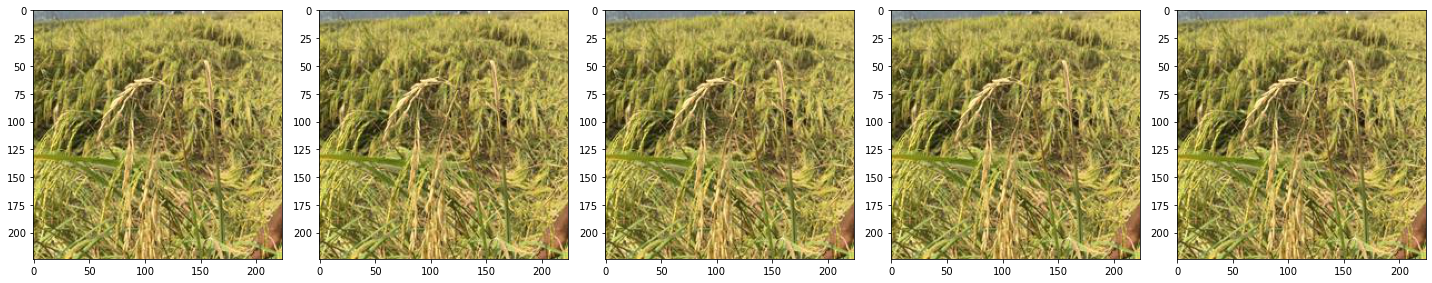

In [221]:
# Plot a few training images
img_array = [train_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

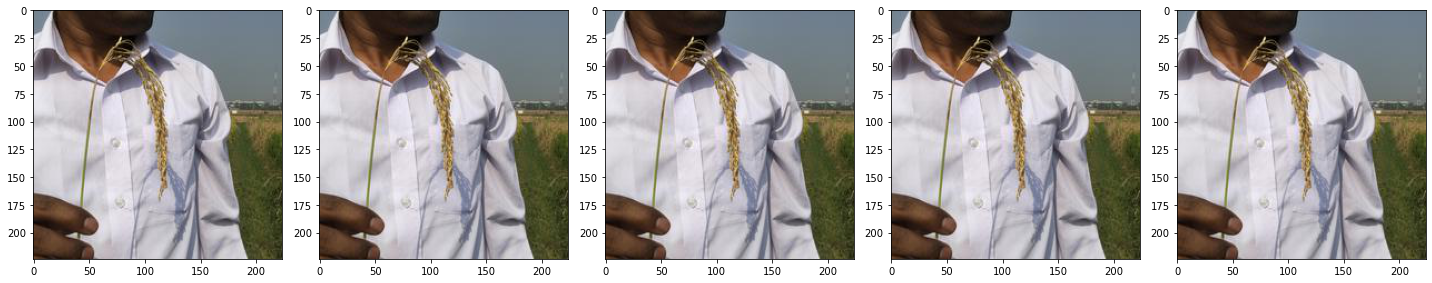

In [117]:
# plot a few val images
img_array  = [val_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

In [128]:
# Model building
#Instatiating A convnet

model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
#model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(24, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(48, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dense(17, activation="softmax"))

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization_10 (Batc (None, 222, 222, 16)      64        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 109, 109, 24)      3480      
_________________________________________________________________
batch_normalization_11 (Batc (None, 109, 109, 24)      96        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 24)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 52, 52, 32)      

In [129]:
EPOCHS=100
BATCH_SIZE=64
LEARNING_RATE=0.0001
history = model.fit_generator(train_data_gen, epochs=EPOCHS,validation_data=val_data_gen)

Epoch 1/100
18/18 [==============================] - 97s 5s/step - loss: 3.1565 - accuracy: 0.1712 - val_loss: 3.4209 - val_accuracy: 0.0783
Epoch 2/100
18/18 [==============================] - 112s 6s/step - loss: 1.9462 - accuracy: 0.4122 - val_loss: 3.2312 - val_accuracy: 0.0854
Epoch 3/100
 6/18 [=========>....................] - ETA: 53s - loss: 1.5750 - accuracy: 0.5461

KeyboardInterrupt: 

In [ ]:
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [197]:
root_dir = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized\\'
save_dir = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\Splitted_Data\\'
classes_dir = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized')

test_ratio = 0.20

os.makedirs(save_dir, exist_ok=True)

for cls in classes_dir:
    
    os.makedirs(save_dir +'train/' + cls)
    os.makedirs(save_dir +'test/' + cls)

    src = root_dir + cls

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print("*****************************")
    print('Image Class: ', (cls))
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))
    print("*****************************")


    lab = os.listdir('C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized')

    for name in train_FileNames:
        shutil.copy(name, save_dir +'train/'+ cls)

    for name in test_FileNames:
        shutil.copy(name, save_dir +'test/' + cls)
            
print("Copying Done!")

*****************************
Image Class:  BLB1
Total images:  138
Training:  110
Testing:  28
*****************************
*****************************
Image Class:  BPH1
Total images:  50
Training:  40
Testing:  10
*****************************
*****************************
Image Class:  BPH2
Total images:  21
Training:  16
Testing:  5
*****************************
*****************************
Image Class:  Brown_Spot1
Total images:  111
Training:  88
Testing:  23
*****************************
*****************************
Image Class:  False_Smut1
Total images:  66
Training:  52
Testing:  14
*****************************
*****************************
Image Class:  False_Smut2
Total images:  27
Training:  21
Testing:  6
*****************************
*****************************
Image Class:  Healthy1
Total images:  96
Training:  76
Testing:  20
*****************************
*****************************
Image Class:  Healthy2
Total images:  71
Training:  56
Testing:  15
********

In [222]:
train_dir = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\Splitted_Data\\train'
test_dir = 'C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\Splitted_Data\\test'

In [228]:
image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(train_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='sparse')
val_data_gen = image_generator.flow_from_directory(test_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='sparse')

Found 1132 images belonging to 17 classes.
Found 294 images belonging to 17 classes.


In [230]:
EPOCHS=100
history = model.fit_generator(train_data_gen, epochs=EPOCHS,validation_data=val_data_gen)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
18/18 [==============================] - 100s 6s/step - loss: 1.5298 - accuracy: 0.5406 - val_loss: 3.0326 - val_accuracy: 0.0510
Epoch 2/100
18/18 [==============================] - 97s 5s/step - loss: 1.0899 - accuracy: 0.6581 - val_loss: 3.8310 - val_accuracy: 0.0510
Epoch 3/100
18/18 [==============================] - 103s 6s/step - loss: 0.7784 - accuracy: 0.7544 - val_loss: 4.5606 - val_accuracy: 0.0510
Epoch 4/100
 2/18 [==>...........................] - ETA: 1:18 - loss: 0.6400 - accuracy: 0.8203

KeyboardInterrupt: 

In [ ]:
model.summary()